In [1]:
from logging import getLogger
from logging.config import dictConfig

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torcheval.metrics import BinaryAUPRC, BinaryAUROC, BinaryPrecisionRecallCurve
from yaml import safe_load

from streamvigil import CSVDataset
from streamvigil.detectors import RAPP

In [2]:
# Logger
with open("./logging.yml", encoding="utf-8") as file:
        config = safe_load(file)
dictConfig(config)
logger = getLogger(__name__)

In [3]:
random_state = 42

# Dataset
train_data = CSVDataset(
    "../data/INSECTS/INSECTS_IncrRecr.csv.gz",
    train=True,
    random_state=random_state,
)
test_data = CSVDataset(
    "../data/INSECTS/INSECTS_IncrRecr.csv.gz",
    train=False,
    random_state=random_state,
)

# DataLoader
train_loader = DataLoader(
    train_data,
    batch_size=128,
)
test_loader = DataLoader(
    test_data,
    batch_size=64,
)

In [4]:
# Anomaly Detector
detector = RAPP(
    encoder_dims=[33, 28, 23, 18],
    decoder_dims=[18, 23, 28, 33],
    batch_norm=True,
)

In [5]:
# Training
epochs = 1
logger.info("Start training the model...")
for epoch in range(epochs):
    logger.info(f"Epoch: {epoch+1}")
    for batch, (X, _) in enumerate(train_loader):
        loss = detector.train(X)

        if batch % 100 == 0:
            logger.info(f"Loss: {loss.item():>7f}")
logger.info("Completed training the model!")

2024-06-05 10:14:57,628 [INFO] __main__: Start training the model...
2024-06-05 10:14:57,629 [INFO] __main__: Epoch: 1
2024-06-05 10:14:58,086 [INFO] __main__: Loss: 0.190528
2024-06-05 10:14:58,298 [INFO] __main__: Loss: 0.093267
2024-06-05 10:14:58,495 [INFO] __main__: Loss: 0.054498
2024-06-05 10:14:58,690 [INFO] __main__: Loss: 0.028267
2024-06-05 10:14:58,827 [INFO] __main__: Completed training the model!


In [6]:
# Area Under the ROC Curve
auroc = BinaryAUROC()
# Area Under the Precision-Recall Curve
auprc = BinaryAUPRC()

pr_curve = BinaryPrecisionRecallCurve()

for X, y in test_loader:
    scores = detector.predict(X)
    auroc.update(scores, y)
    auprc.update(scores, y)
    pr_curve.update(scores, y)

# Compute evaluation scores
logger.info(f"AUROC Score: {auroc.compute()}")
logger.info(f"AUPRC Score: {auprc.compute()}")

logger.info("Completed the evaluation of the model!")

2024-06-05 10:15:00,137 [INFO] __main__: AUROC Score: 0.48613540135412975
2024-06-05 10:15:00,141 [INFO] __main__: AUPRC Score: 0.011366961523890495
2024-06-05 10:15:00,142 [INFO] __main__: Completed the evaluation of the model!


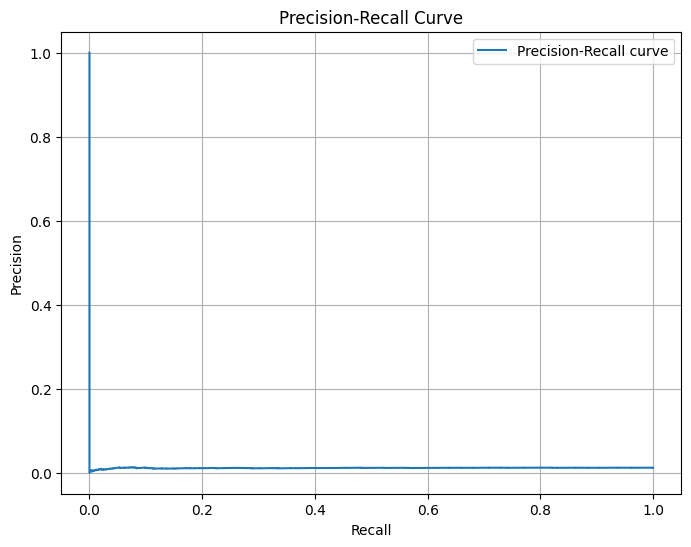

In [7]:
# Visualize Precision-Recall Curve
precision, recall, thresholds = pr_curve.compute()

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.grid()
plt.show()